In [28]:
import os
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier, Pool
import matplotlib.pyplot as plt
from scipy import stats



#Feature importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler


#importing machine learning libraries
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pickle



#Secondary imports
import pandas_profiling as pp
from scipy.stats import pearsonr
import pickle


%matplotlib inline

## Reading Datasets

In [29]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample = pd.read_csv('sample_submission.csv')



/usr/local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (746,835) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (700,731,740,752,761,789,811,820,829,841,850) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [30]:
cols = np.load('final_col.npy').tolist()

In [33]:
len(cols)

167

In [32]:
remove = []

for i in range(len(cols)):
    value = (1 - train[train[cols[i]]!=0].shape[0]/train.shape[0]) * 100
    if value > 60:
        remove.append(cols[i])


for i in range(len(remove)):
    cols.remove(remove[i])

In [34]:
lgbb = lgb.LGBMClassifier()
# ctb = CatBoostClassifier(verbose=False)

# xgbb = xgb.XGBClassifier()

n_split = 5
avg1 = 0
avg2 = 0
count=0

skf = StratifiedKFold(n_splits = n_split, shuffle = True)

for train_index, test_index in skf.split(train[cols], train['Col2']):
    print("hello", count)
    count+=1
   
    trainx, testx = train[cols].iloc[train_index], train[cols].iloc[test_index]
    trainy, testy = train['Col2'].iloc[train_index], train['Col2'].iloc[test_index]
    
    lgbb.fit(trainx, trainy)
#     ctb.fit(trainx, trainy)
    avg1 += accuracy_score(lgbb.predict(testx), testy)
#     avg2 += accuracy_score(ctb.predict(testx), testy)


print("Average accuracy was: ", avg1/n_split)#,"and", avg2/6)
    
    

hello 0
hello 1
hello 2
hello 3
hello 4
Average accuracy was:  0.898122333391958


In [122]:
lgbb.fit(data, target)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [35]:
result = lgbb.predict(test[cols])

In [36]:
submission = pd.DataFrame()
submission['Col1'] = test['Col1']
submission['Col2'] = result

In [37]:
submission.to_csv('submission.csv', index=False)

In [38]:
submission.head()

,Col1,Col2
0,RIGD58ZWD,0
1,RIH660YDS,0
2,RIH660Q96,0
3,RIYDO15W1,0
4,RIYBGC1ZD,0


### Finding missing values, and selecting  columns with less than 5% missing values

In [40]:
seta = cols.copy()

In [41]:
percent_missing = train[seta].isnull().sum() * 100 / len(train[seta])
missing_value_df = pd.DataFrame({'column_name': train[seta].columns,
                                 'percent_missing': percent_missing})

missing_value_df.sort_values('percent_missing', ascending=False, inplace=True)
missing_value_df.reset_index(inplace=True, drop=True)

In [42]:
try_col = missing_value_df[missing_value_df['percent_missing']<5].sort_values('percent_missing', ascending=False).column_name.values.tolist()

In [43]:
len(cols)

167

In [44]:
len(try_col)

167

In [45]:
final_col = sorted(try_col, key = lambda x: int(x[3:]))

In [ ]:
np.save('final_col.npy', final_col)

### Re-profiling of pandas, based on new features

In [23]:
train.columns.difference(profile.get_rejected_variables())

Index(['Col1', 'Col10', 'Col100', 'Col1000', 'Col1001', 'Col1002', 'Col1003',
       'Col1004', 'Col1005', 'Col1006',
       ...
       'Col892', 'Col893', 'Col894', 'Col90', 'Col91', 'Col913', 'Col915',
       'Col920', 'Col930', 'Col931'],
      dtype='object', length=491)

In [21]:
len(profile.get_rejected_variables())

1904

In [46]:
rf = RandomForestClassifier()


#Creating features from training dataset
features1 = train[try_col]


targets = train['Col2']

rf.fit(features1, targets) 

feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = try_col,
                                    columns=['importance']).sort_values('importance',ascending=False)
print(feature_importances)

/usr/local/lib/python3.5/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


         importance
Col10          0.03
Col11          0.03
Col168         0.03
Col26          0.02
Col186         0.02
Col182         0.02
Col205         0.02
Col196         0.02
Col25          0.02
Col202         0.02
Col198         0.02
Col591         0.02
Col189         0.01
Col188         0.01
Col120         0.01
Col51          0.01
Col49          0.01
Col1020        0.01
Col1002        0.01
Col1272        0.01
Col1014        0.01
Col1666        0.01
Col1074        0.01
Col58          0.01
Col47          0.01
Col75          0.01
Col50          0.01
Col54          0.01
Col1028        0.01
Col73          0.01
...             ...
Col1283        0.00
Col123         0.00
Col1037        0.00
Col1009        0.00
Col85          0.00
Col1167        0.00
Col1079        0.00
Col1025        0.00
Col1219        0.00
Col1361        0.00
Col1140        0.00
Col1301        0.00
Col65          0.00
Col1273        0.00
Col1285        0.00
Col84          0.00
Col61          0.00
Col1631        0.00


In [48]:
threshold = 0.001

In [51]:
thres_col = sorted(feature_importances[feature_importances.importance > threshold].reset_index()['index'].values.tolist(), key = lambda x: int(x[3:]))
print(len(thres_col))

167


In [52]:
train_data = train[feature_importances[feature_importances.importance > threshold].reset_index()['index'].values.tolist()]
test_data = test[feature_importances[feature_importances.importance > threshold].reset_index()['index'].values.tolist()]

In [54]:
train_data

,Col10,Col11,Col168,Col26,Col186,Col182,Col205,Col196,Col25,Col202,...,Col88,Col62,Col1057,Col1229,Col1265,Col1221,Col90,Col60,Col1589,Col34
0,"28,715.09","9,114.59","624,714.21",0.12,0.33,35.67,"12,166.67","4,166.67",0.14,0.00,...,1,1,1,1,1,1,1,1,0,1
1,"166,697.39","201,351.81","5,282,475.53",0.81,0.00,8.20,0.00,0.00,0.75,23.00,...,1,2,0,0,1,0,1,2,0,0
2,"6,906,324.11","9,368,337.95","222,613,622.60",0.78,0.00,75.60,"31,000.00",0.00,0.81,"1,116.08",...,1,1,1,1,0,0,1,1,0,0
3,"423,661.16","430,484.82","28,215,601.57",0.39,0.00,140.40,0.00,0.00,-0.13,891.00,...,1,2,0,0,0,1,1,2,0,0
4,"5,446,532.15","3,473,444.14","472,699,055.80",0.62,0.00,261.00,"121,000.00",0.00,-0.11,"3,079.85",...,1,0,2,0,0,1,1,0,1,0
5,"2,116,667.49","1,488,867.88","22,232,299.40",0.59,0.00,15.00,"12,500.00",0.00,-1.22,0.00,...,1,0,0,1,0,0,1,0,1,0
6,"36,189.90","40,650.46","182,695.00",0.55,0.43,1.71,500.00,500.00,0.58,8.21,...,1,2,0,1,0,0,1,2,1,1
7,"55,217.43","84,779.20","674,028.00",0.29,0.00,2.29,"5,714.29",0.00,0.39,0.00,...,0,1,1,3,1,1,0,1,0,1
8,"2,380.50","3,336.16","47,081.50",0.15,3.00,7.00,"1,983.33","1,983.33",-0.26,35.46,...,0,1,1,1,1,1,0,2,1,1
9,"58,899.39","89,512.54","622,538.00",0.22,1.57,3.00,"2,142.86","2,142.86",0.18,124.86,...,1,1,1,0,2,1,1,1,2,1


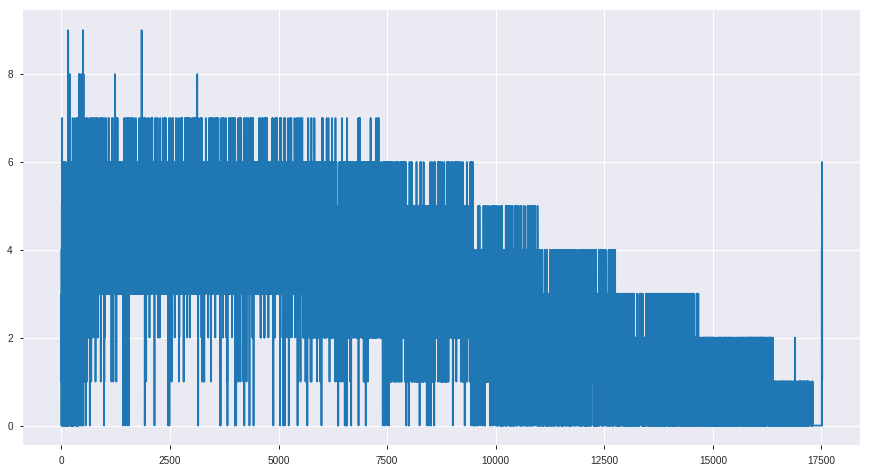

In [254]:
plt.figure(figsize = (15, 8))
plt.plot(train_data['Col120'].values)

In [227]:
lgbb = lgb.LGBMClassifier()
lgbb.fit(train_data.values, train['Col2'].values)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [228]:
xgbb = xgb.XGBClassifier()
xgbb.fit(train_data.values, train['Col2'].values)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [229]:
ctb = CatBoostClassifier(verbose=False)


ctb.fit(train_data.values, train['Col2'].values)

In [230]:
result1 = lgbb.predict_proba(test_data.values)
result2 = xgbb.predict_proba(test_data.values)
result3 = ctb.predict_proba(test_data.values)

In [231]:
resultt = 0.4 * result1 + 0.2 * result2 + 0.4 * result3

In [232]:
result = np.argmax(resultt, axis=1)

In [233]:
submission = pd.DataFrame()
submission['Col1'] = test['Col1']
submission['Col2'] = result

In [234]:
submission.to_csv('submission.csv', index=False)

In [235]:
submission.head()

,Col1,Col2
0,RIGD58ZWD,0
1,RIH660YDS,0
2,RIH660Q96,0
3,RIYDO15W1,0
4,RIYBGC1ZD,0
